# Setup and downloading data

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
!pip install kaggle

In [ ]:
DATA = Path('/content/gdrive/MyDrive/DAT255/formula1-classifier')
DATA.mkdir(exist_ok=True, parents=True)

In [ ]:
from google.colab import files
uploaded = files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
if not os.path.isfile(DATA/'formula-one-cars.zip'):
    !kaggle datasets download -d vesuvius13/formula-one-cars -p $DATA

# Exploring data

In [ ]:
import shutil
if not os.path.exists(DATA/'Formula One Cars'):
    shutil.unpack_archive(DATA/'formula-one-cars.zip', extract_dir=DATA)

In [ ]:
DATA.ls()

(#4) [Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/formula-one-cars.zip'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/models'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/images')]

In [ ]:
(DATA/'Formula One Cars').ls()

(#8) [Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/AlphaTauri F1 car'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/Ferrari F1 car'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/McLaren F1 car'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/Mercedes F1 car'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/Racing Point F1 car'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/Red Bull Racing F1 car'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/Renault F1 car'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/Williams F1 car')]

In [ ]:
path = DATA/'Formula One Cars'
(path/'AlphaTauri F1 car').ls()

(#123) [Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/AlphaTauri F1 car/00000005.jpg'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/AlphaTauri F1 car/00000010.jpg'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/AlphaTauri F1 car/00000011.jpg'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/AlphaTauri F1 car/00000014.jpg'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/AlphaTauri F1 car/00000015.jpg'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/AlphaTauri F1 car/00000018.jpg'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/AlphaTauri F1 car/00000020.jpg'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/AlphaTauri F1 car/00000022.jpg'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/AlphaTauri F1 car/00000024.jpg'),Path('/content/gdrive/MyDrive

In [ ]:
test_img = (path/'AlphaTauri F1 car').ls()[0]
test_img

Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars/AlphaTauri F1 car/00000005.jpg')

In [ ]:
img = load_image(test_img)
img

In [ ]:
img.shape

In [ ]:
for img in (path/'AlphaTauri F1 car').ls()[:5]:
    img = load_image(img)
    display(img)
    print(img.shape)
    print("#"*40)

# Clean dataset

In [ ]:
from PIL import Image
for team_folder in os.listdir(path):
    team_path = os.path.join(path, team_folder)
    for img_file in os.listdir(team_path):
      img_path = os.path.join(team_path, img_file)
      try:
        img = Image.open(img_path)
        img.verify()
      except:
        print(f"Deleting '{team_folder}/{img_file}' because of curruption")
        os.remove(img_path)

# Create data loader

In [ ]:
dls = ImageDataLoaders.from_folder(path, train = ["train"], valid_pct=0.2)

In [ ]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = cars.dataloaders(path)

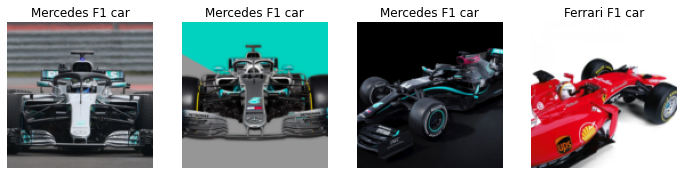

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

# Train model

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
learn.lr_find()

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
learn.fine_tune(4, 1.7e-3)

# Evaluation

In [ ]:
learn.show_results()

In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs, nrows=8, )
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

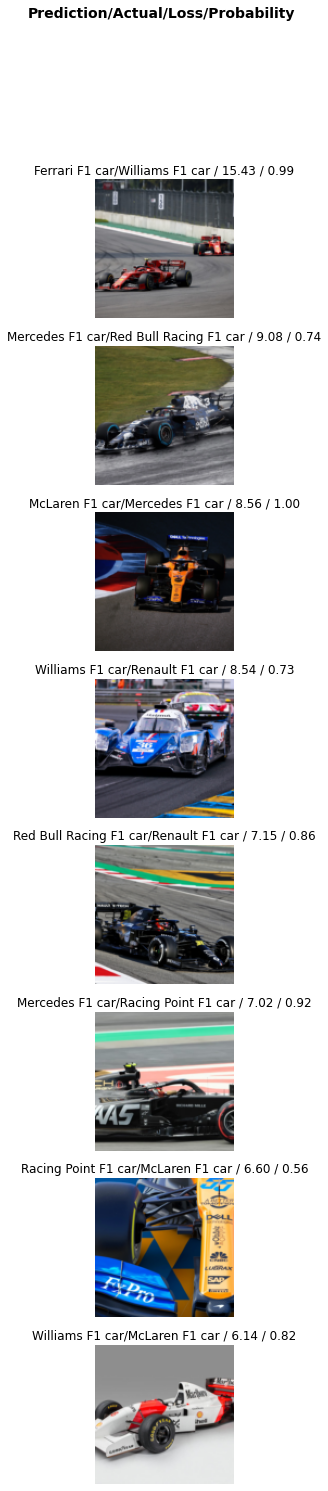

In [ ]:
plot_top_losses_fix(interp, k=8)

In [ ]:
from fastai.vision.widgets import *

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
a = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


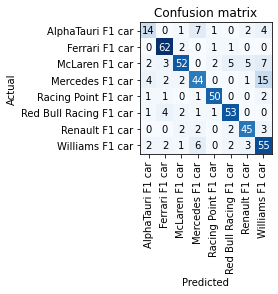

In [ ]:
a.plot_confusion_matrix()

In [ ]:
from google.colab import files
files.upload()

Saving utils.py to utils.py


{'utils.py': b'# From https://forums.fast.ai/t/plotting-metrics-after-learning/69937/3\r\n\r\nfrom fastai.imports import *\r\nfrom fastai.torch_core import *\r\nfrom fastai.learner import *\r\nfrom fastai.vision.all import *\r\n    \r\n@patch\r\n@delegates(subplots)\r\ndef plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, endnames=-1, **kwargs):\r\n    metrics = np.stack(self.values)\r\n    names = self.metric_names[1:endnames]\r\n    n = len(names) - 1\r\n    if nrows is None and ncols is None:\r\n        nrows = int(math.sqrt(n))\r\n        ncols = int(np.ceil(n / nrows))\r\n    elif nrows is None: nrows = int(np.ceil(n / ncols))\r\n    elif ncols is None: ncols = int(np.ceil(n / nrows))\r\n    figsize = figsize or (ncols * 6, nrows * 4)\r\n    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)\r\n    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]\r\n    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):\r\n   

In [ ]:
pip install fastai-amalgam

In [ ]:
from utils import gradcam

In [ ]:
for img in random.choices(dls.valid_ds, k=12):
  plt.imshow(img[0])
  plt.show()

TypeError: ignored

In [ ]:
img = dls.valid_ds[0]
img[0]
gcam = gradcam(learn, img[0], show_original=True)
#plt.imshow(img[0])

TypeError: ignored

/usr/local/lib/python3.7/dist-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


RuntimeError: ignored

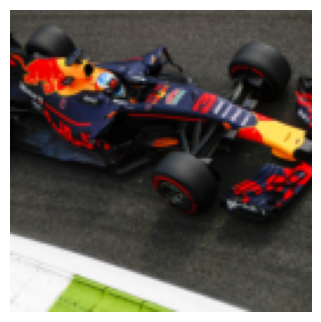

In [ ]:
for img in random.choices(dls.valid_ds, k=12):
    gcam = gradcam(learn, img[0], show_original=True)
    f = plt.figure(figsize=(10,8))
    plt.imshow(gcam)
    plt.title(f"Activity: {img[1]}")
    plt.axis('off')
    plt.show()

In [ ]:
(DATA).ls()

(#3) [Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/formula-one-cars.zip'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/Formula One Cars'),Path('/content/gdrive/MyDrive/DAT255/formula1-classifier/models')]

In [ ]:
NB_DIR = Path.cwd()
MODELS = DATA/'models'
MODELS.mkdir(exist_ok=True)

In [ ]:
learn.export(MODELS/'f1_classifier_v2')